In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
loan=pd.read_csv('../.Database/cleaned_loan.csv')
loan.shape

(257777, 26)

In [3]:
X=loan.drop(columns=['loan_status','loan_status_grouped','emp_title','purpose','title','issue_d','grade', 'addr_state'])
y=loan['loan_status_grouped']

In [4]:
X.shape

(257777, 18)

In [5]:
X.head()

,annual_inc,delinq_2yrs,dti,emp_length,funded_amnt,home_ownership,inq_last_6mths,installment,int_rate,loan_amnt,mths_since_last_delinq,pub_rec,sub_grade,term,total_acc,total_pymnt,acc_now_delinq,log_annual_inc
0,24000.0,0.0,27.65,10+ years,5000.0,RENT,1.0,162.87,10.65,5000.0,0.0,0.0,B2,36 months,9.0,5861.071414,0.0,10.085809
1,30000.0,0.0,1.00,< 1 year,2500.0,RENT,5.0,59.83,15.27,2500.0,0.0,0.0,C4,60 months,4.0,1008.710000,0.0,10.308953
2,12252.0,0.0,8.72,10+ years,2400.0,RENT,2.0,84.33,15.96,2400.0,0.0,0.0,C5,36 months,10.0,3003.653644,0.0,9.413444
3,49200.0,0.0,20.00,10+ years,10000.0,RENT,1.0,339.31,13.49,10000.0,35.0,0.0,C1,36 months,37.0,12226.302212,0.0,10.803649
4,36000.0,0.0,11.20,3 years,5000.0,RENT,3.0,156.46,7.90,5000.0,0.0,0.0,A4,36 months,12.0,5631.377753,0.0,10.491274


In [6]:
# Encode sub_grade into numerical values
def sub_grades_encoding(x):
    grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
    number_mapping = {'1': 0.8, '2': 0.6, '3': 0.4, '4': 0.2, '5': 0.0}
    
    val = grade_mapping.get(x[0], 0) + number_mapping.get(x[1], 0)
    return val

X['sub_grade']= X['sub_grade'].apply(sub_grades_encoding)

#Separate numerical and non-numerical columns
ordinal_columns = ['emp_length']
categorical_columns = ['home_ownership', 'term']
numerical_columns = X.select_dtypes(include=['float64']).columns

# Apply Label Encoding to ordinal columns before splitting
le = LabelEncoder()
for col in ordinal_columns:
    X[col] = le.fit_transform(X[col])

# Apply OneHotEncoding to categorical columns before splitting
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Now perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Ensure the train and test sets have the same structure (dummies already handled)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Apply scaling to numerical columns
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [7]:
# Convert columns in X_train to numeric
boolean_columns = ['home_ownership_ANY','home_ownership_MORTGAGE', 'home_ownership_NONE','home_ownership_OTHER','home_ownership_OWN','home_ownership_RENT','term_ 36 months','term_ 60 months']
X_train[boolean_columns] = X_train[boolean_columns].astype(int)
X_test[boolean_columns] = X_test[boolean_columns].astype(int)

# Dropping variables to avoid multicolinearity and quasi-seperation
X_train = X_train.drop(['home_ownership_NONE', 'funded_amnt', 'total_pymnt'], axis=1)
X_test = X_test.drop(['home_ownership_NONE', 'funded_amnt', 'total_pymnt'], axis=1)

# Convert y_train to numeric (if it is not already)
y_train = pd.to_numeric(y_train, errors='coerce')

# Drop rows with NaN values in X_train or y_train
X_train = X_train.dropna()
y_train = y_train[X_train.index]  # Ensure y_train matches X_train

X_train

,annual_inc,delinq_2yrs,dti,emp_length,inq_last_6mths,installment,int_rate,loan_amnt,mths_since_last_delinq,pub_rec,...,total_acc,acc_now_delinq,log_annual_inc,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,term_ 36 months,term_ 60 months
39992,-0.657968,-0.339174,-1.238745,5,-0.767136,-0.257110,0.839027,-0.457196,-0.688929,-0.325202,...,-1.025073,-0.052534,-1.173114,0,0,0,0,1,1,0
194138,-0.326435,0.973358,1.346995,6,-0.767136,0.049582,-0.312557,-0.090579,0.236369,-0.325202,...,-0.431955,-0.052534,-0.311747,0,1,0,0,0,1,0
146986,-0.438905,-0.339174,0.999333,1,1.825223,-0.508203,-1.416537,-0.512189,0.544802,-0.325202,...,0.076432,-0.052534,-0.563600,0,0,0,0,1,1,0
240030,0.427205,-0.339174,0.638888,1,-0.767136,1.543010,-0.122138,2.597944,-0.688929,-0.325202,...,2.957292,-0.052534,0.847819,0,0,0,1,0,0,1
188312,0.452839,3.598422,-0.396430,1,-0.767136,-0.403425,-0.843012,-0.457196,-0.556744,-0.325202,...,-0.008299,-0.052534,0.877338,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,-0.418717,-0.339174,0.645279,3,-0.767136,-0.517591,-0.396433,-0.594677,1.381978,-0.325202,...,-0.262492,-0.052534,-0.515936,0,1,0,0,0,1,0
103694,0.162320,-0.339174,-0.882135,4,0.961103,-0.003254,1.174528,-0.273888,-0.688929,-0.325202,...,-0.940342,-0.052534,0.513410,0,0,0,0,1,1,0
131932,-0.760504,-0.339174,0.038148,6,-0.767136,-0.326853,0.050146,-0.457196,1.117606,-0.325202,...,-0.093030,-0.052534,-1.540407,0,0,0,0,1,1,0
146867,0.281945,-0.339174,-1.256639,6,0.096984,-1.209010,-1.353064,-1.190430,-0.688929,-0.325202,...,-0.347224,-0.052534,0.671554,0,1,0,0,0,1,0


In [8]:
np.asarray(X_train)

array([[-0.6579681 , -0.33917414, -1.23874474, ...,  1.        ,
         1.        ,  0.        ],
       [-0.32643505,  0.97335786,  1.34699501, ...,  0.        ,
         1.        ,  0.        ],
       [-0.43890541, -0.33917414,  0.99933252, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [-0.7605041 , -0.33917414,  0.038148  , ...,  1.        ,
         1.        ,  0.        ],
       [ 0.2819452 , -0.33917414, -1.25663914, ...,  0.        ,
         1.        ,  0.        ],
       [-0.31618145, -0.33917414, -1.16461083, ...,  0.        ,
         1.        ,  0.        ]])

In [9]:
# Using statsmodels library to run Logit Regression

# Add a constant to the independent variables
X_train_with_const = sm.add_constant(X_train)
X_test_with_const = sm.add_constant(X_test)

# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train_with_const)

# Fit the model and obtain the result object
result = logit_model.fit(maxiter=2000)

# Print the summary of the logistic regression results
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.476084
         Iterations 1079
                            Logit Regression Results                           
Dep. Variable:     loan_status_grouped   No. Observations:               206221
Model:                           Logit   Df Residuals:                   206200
Method:                            MLE   Df Model:                           20
Date:                 Fri, 25 Oct 2024   Pseudo R-squ.:                 0.08444
Time:                         00:30:16   Log-Likelihood:                -98178.
converged:                        True   LL-Null:                   -1.0723e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.5256   1.79e+05  -8.51e-06      1.000   -

Accuracy: 0.78 

Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.98      0.88     40328
         1.0       0.52      0.09      0.16     11228

    accuracy                           0.78     51556
   macro avg       0.66      0.53      0.52     51556
weighted avg       0.74      0.78      0.72     51556



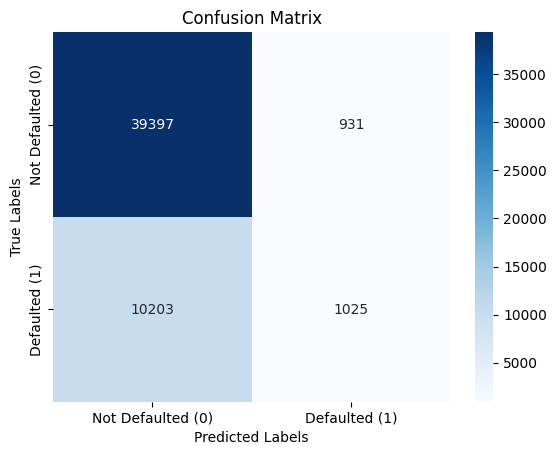

In [10]:
# Make predictions
threshold = 0.5
predicted_probs = result.predict(X_test_with_const)  # Predict probabilities
predicted_classes = np.where(predicted_probs < threshold, 0, 1)

# Generate evaluation metrics
accuracy = accuracy_score(y_test, predicted_classes)
class_report = classification_report(y_test, predicted_classes)
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Print the accuracy score and classication report
print(f'Accuracy: {accuracy:.2f}',"\n")
print("Classification Report:\n", class_report)

# Plot confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=True, xticklabels=['Not Defaulted (0)', 'Defaulted (1)'], yticklabels=['Not Defaulted (0)', 'Defaulted (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

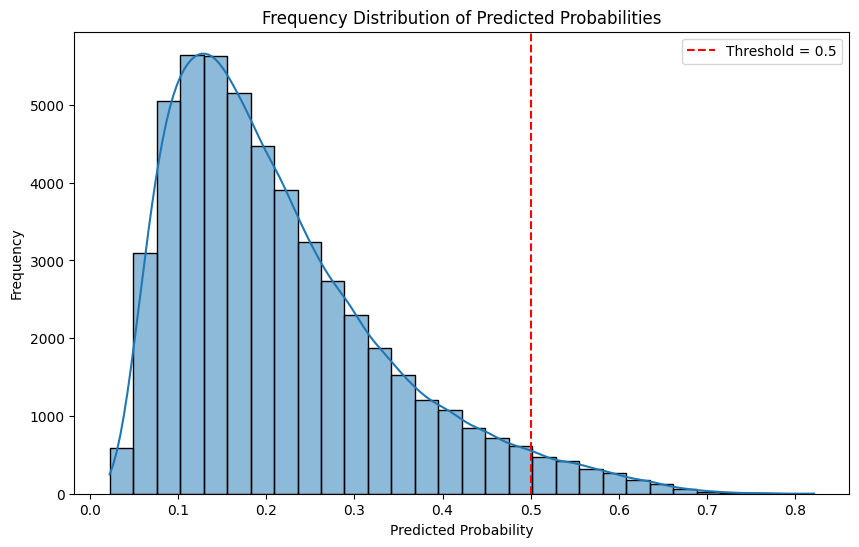

In [11]:
# Don't keep this
# Just to show how weird the predictions from statsmodels logit regression are

plt.figure(figsize=(10, 6))
sns.histplot(predicted_probs, bins=30, kde=True)  # Use KDE for a smoother curve
plt.title('Frequency Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold = {}'.format(threshold))
plt.legend()
plt.show()